In [1]:
import flopy
import os
import sys
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

if sys.platform.lower()=='linux':
    datadir = Path('/scratch/users/ianpg/SWIlarge/data')
    workdir = Path('/scratch/users/ianpg/SWIlarge/work')
    MPSdir = datadir.joinpath('lith/sgems/MPS')
    GISdir = datadir.joinpath('GIS')
    import mplleaflet
elif sys.platform.lower()=='darwin':
    datadir = Path('../data')
    workdir = Path('../work')
    MPSdir = Path('/Users/ianpg/Dropbox/temp_convenience/SWIlarge/data/lith/sgems/MPS')
    GISdir = Path('/Users/ianpg/Dropbox/temp_convenience/SWIlarge/data/GIS')

nmgwmdir_empty = datadir.joinpath('nmgwmdir_empty') #<-- removed everything but DIS
nmgwmdir_cal = datadir.joinpath('Calibrated_small') #<-- removed RCH, WEL, GLO, LST from the NAM file to load much faster
figdir = workdir.joinpath('figs')
outputdir = workdir.joinpath('output')

import config
from set_rc import *

import pandas as pd
import shapefile as sf #in case you dont have it, form anaconda prompt: pip install pyshp
from flopy.utils.gridgen import Gridgen
from flopy.utils.reference import SpatialReference
from  pyproj import Proj

p = Proj("epsg:26910")
xll=595855
yll = 4059438
rotation = -13.5

flopy is installed in /Users/ianpg/anaconda/envs/SWIenv/lib/python3.6/site-packages/flopy
system: darwin


In [2]:

#%% Useful functions
def load_obj(dirname,name):
    import pickle
    with open(Path(dirname).joinpath(name + '.pkl').as_posix(), 'rb') as f:
        return pickle.load(f)

def save_obj(dirname,obj,name):
    import pickle
    with open(Path(dirname).joinpath(name + '.pkl').as_posix(), 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

#Create new MC_file
def create_MC_file():
    import datetime
    ts = datetime.datetime.now().strftime('%Y-%m-%d-%H-%M')
    MC_dir = Path(os.path.join(m.model_ws, 'MC_expt_' + ts))
    if not MC_dir.exists():
        MC_dir.mkdir()
    m.MC_file = MC_dir.joinpath('expt.txt')
    with m.MC_file.open('w') as wf:
        wf.close
    print(m.MC_file)
    return

#nearest value in array
def find_nearest(array,value):
    import numpy as np
    idx = (np.abs(array-value)).argmin()
    idx.astype('int')
    return array[idx]

#take distance in meters, return column in model
def loc_to_col(locs):
    cols = [int(find_nearest((np.arange(ncol)*delc),loc)) for loc in locs]
    return cols

#make a line across the grid
def get_line(start, end,allrows=1,nrow=None):
    """Bresenham's Line Algorithm
    Produces a list of tuples from start and end

    >>> points1 = get_line((0, 0), (3, 4))
    >>> points2 = get_line((3, 4), (0, 0))
    >>> assert(set(points1) == set(points2))
    >>> print points1
    [(0, 0), (1, 1), (1, 2), (2, 3), (3, 4)]
    >>> print points2
    [(3, 4), (2, 3), (1, 2), (1, 1), (0, 0)]
    """
    # Setup initial conditions
    x1, y1 = start
    x2, y2 = end
    dx = x2 - x1
    dy = y2 - y1

    # Determine how steep the line is
    is_steep = abs(dy) > abs(dx)

    # Rotate line
    if is_steep:
        x1, y1 = y1, x1
        x2, y2 = y2, x2

    # Swap start and end points if necessary and store swap state
    swapped = False
    if x1 > x2:
        x1, x2 = x2, x1
        y1, y2 = y2, y1
        swapped = True

    # Recalculate differentials
    dx = x2 - x1
    dy = y2 - y1

    # Calculate error
    error = int(dx / 2.0)
    ystep = 1 if y1 < y2 else -1

    # Iterate over bounding box generating points between start and end
    y = y1
    points = []
    for x in range(x1, x2 + 1):
        if allrows==1:
            if nrow is None:
                nrow = m.nrow
            for row in range(nrow):
                coord = (y, row, x) if is_steep else (x, row, y)
                points.append(coord)
        else:
            coord = (y, x) if is_steep else (x, y)
            points.append(coord)
        error -= abs(dy)
        if error < 0:
            y += ystep
            error += dx

    # Reverse the list if the coordinates were swapped
    if swapped:
        points.reverse()
    return points


#make all cells=0 above the line from get_line()
#Calculate freshwater head based on column of saltwater above each node (rho*g*z)
def shade_above(nlay,nrow,ncol,point_list,third_dim=1):
    import numpy as np
    grd = np.ones((nlay,nrow,ncol),dtype='int')
    ocean_hf = []
    if len(point_list)==0:
        return grd,ocean_hf
    for (lay,row,col) in point_list:
        grd[lay,:,col] = -1 #assign ocean ibound to -1
        grd[:lay,:,col] = 0 #assign cells above ocean to 0
        hf = densefresh/densesalt*ocean_elev - (densesalt - densefresh)/densefresh*(henry_botm[lay] +.5*delv)
        for irow in range(nrow):
            ocean_hf.append((int(lay),int(irow),int(col),hf))
    ocean_hf = tuple(np.array(ocean_hf).T)
    ocean_hf = (ocean_hf[0].astype('int'),
                ocean_hf[1].astype('int'),
                ocean_hf[2].astype('int'),
                ocean_hf[3])
    return grd,ocean_hf

def get_ocean_right_edge(m,ocean_line_tuple,startlay=None,col=None):
    import numpy as np
    point_list = []
    if col is None:
        col = m.ncol-1
    #If there is no vertical side boundary, return bottom-right corner node
    if len(ocean_line_tuple)==0:
        if startlay is None:
            startlay = 0
    elif max(ocean_line_tuple[0])==m.nlay:
        startlay = m.nlay
    elif max(ocean_line_tuple[0])<m.nlay:
        startlay = max(ocean_line_tuple[0])
    for lay in range(startlay,m.nlay):
        for row in range(m.nrow):
            point_list.append((lay,row,col))
    point_list = tuple(np.array(point_list).T)
    return point_list

def add_pumping_wells(wel_data,ssm_data,n_wells,flx,rowcol,kper):
    itype = flopy.mt3d.Mt3dSsm.itype_dict()
    new_weldata = wel_data
    new_ssmdata = ssm_data
    wel_cells = []
    for k in range(n_wells):
        row,col = rowcol[k]
        for i in range(nper):
            if i in kper:
                for j in range(nlay):
                    #WEL {stress_period: [lay,row,col,flux]}
                    new_weldata[i].append([j,row,col,-flx[k]*delv_weight[j]])
                    wel_cells.append((j,row,col))
                    #SSM: {stress_period: [lay,row,col,concentration,itype]}
                    new_ssmdata[i].append([j,row,col,Cfresh,itype['WEL']]) #since it's a sink, conc. doesn't matter
            else:
                for j in range(nlay):
                    #WEL {stress_period: [lay,row,col,flux]}
                    new_weldata[i].append([j,row,col,0])
                    #SSM: {stress_period: [lay,row,col,concentration,itype]}
                    new_ssmdata[i].append([j,row,col,Cfresh,itype['WEL']]) #since it's a sink, conc. doesn't matter
                    wel_cells.append((j,row,col))
                continue
    wel_cells = tuple(np.array(list(set(wel_cells))).T)
    return new_weldata, new_ssmdata,wel_cells

#Add recharge if desired
def make_rech_array(low=1e-2,high=1e0):
    import scipy.stats as sts
    llow,lhigh = np.log10((low,high))
    rech = np.exp(sts.uniform.rvs(size=1,loc=llow,scale=lhigh-llow)[0])
    return rech/(nrow*ncol)

def add_recharge_cells(recharge_generator,const=1,*args):
    if const==1:
        rech_data = recharge_generator(*args)
    else:
        rech_data = {}
        for i in range(nper):
            rech_array = recharge_generator(*args)
        rech_data[i] = rech_array
    return rech_data

def sample_dist(distclass,size,*args):
    smp = distclass.rvs(*args,size=size)
    if size==1:
        smp=smp[-1]
    return smp

def write_sample(fname,varname,distclass,sample):
    fout= open(fname,"a")
    fout.write(varname + ',' + str(type(distclass)) + ',' + str(sample) + '\n')
    fout.close()
    return

def truncate_grf(grid,lith_props,hk_vals,log10trans=True,plotyn=False,saveyn=False):
    grid_cutoffs = []
    for q in np.cumsum(lith_props):
        grid_cutoffs.append(np.quantile(grid,q))

    if plotyn:
        h = plt.hist(grid.flatten())
        for cutoff in grid_cutoffs:
            plt.vlines(cutoff,0,14000)
        plt.show()

    outgrid = np.ones(grid.shape,dtype=np.float32)
    for i,cutoff in reversed(list(enumerate(grid_cutoffs))):
        outgrid[np.where(grid<cutoff)] = hk_vals[i]

    if plotyn:
        f,axs = plt.subplots(2,1,sharex=True)
        axs[0].imshow(grid[:,0,:])
        axs[1].imshow(outgrid[:,0,:])
        if saveyn:
            plt.savefig(m.MC_file.parent.joinpath('Truncated_GRF.png').as_posix(),resolution=300)
    if log10trans:
        return np.power(10,outgrid)
    else:
        return outgrid

def make_timestamp(YMD=True,HM=True):
    import datetime
    if YMD:
        ymd = '%Y%m%d'
    else:
        ymd = ''
    if HM:
        hm = '%H%M'
    else:
        hm = ''
    if YMD and HM:
        sep = '_'
    else:
        sep = ''
    return datetime.datetime.now().strftime('{}{}{}'.format(ymd,sep,hm))

def pec_num(delv,delc,delr,al):
    delL = (delv,delc,delr) #length in the lay,row,col directions
    pec_num = [round(d/al,2) for d in delL]
    for num,point  in zip(pec_num,('lay','row','col')):
        print('Pe = {} in the {} direction'.format(num,point))
    return pec_num

#%%

In [3]:
%%time
m_nm= flopy.modflow.Modflow.load('nm_cali.nam',version='mf2k',verbose=False,check=False,model_ws=nmgwmdir_cal.as_posix())
# m = flopy.modflow.Modflow.load(nmgwmdir_uncal.joinpath('C1-12_copy.nam').as_posix(),version='mf2k',verbose=False,check=False,model_ws=outputdir.joinpath('C1').as_posix())
m_nm.exe_name = config.mf2000exe
if not m_nm.DIS.lenuni==2:
    m_nm.DIS.delr *= .3048
    m_nm.DIS.delc *= .3048
    m_nm.DIS.top *= .3048
    m_nm.DIS.botm *= .3048
m_nm.DIS.lenuni = 2
m_nm.DIS.itmuni=4
m_nm.DIS.rotation=-13.5
# m_nm.DIS.xul = xll + 18288.0*np.sin(13.5*180/np.pi) #upper left UTM Zone 10N
# m_nm.DIS.yul = yll + 18288.0*np.cos(13.5*180/np.pi)  #upper left UTM Zone 10N
m_nm.DIS.proj4_str = p.srs
m_nm.modelgrid.set_coord_info(xoff=xll, yoff=yll, angrot=rotation, proj4=p.srs)#,epsg='nad83-utm-zone-10n')


CPU times: user 1min 27s, sys: 1.1 s, total: 1min 28s
Wall time: 1min 33s


In [554]:
start_nm_yr = 1979
start_nm_mo = 10
start_nm_str = 'Oct 1979'
end_nm_yr = 2011
end_nm_mo = 9
end_nm_str = 'Sep 2011'
Lt_nm = ( (end_nm_yr + end_nm_mo/12)  - (start_nm_yr + start_nm_mo/12) )     *365
start_nm_datetime='{}/1/{}'.format(start_nm_mo,start_nm_yr)



start_m_yr = 1979
start_m_mo = 10
start_m_str = 'Oct 1979'
# end_m_yr = 2011
# end_m_mo = 9
# end_m_str = 'Sep 2011'
# Lt_m = ( (end_m_yr + end_m_mo/12)  - (start_m_yr + start_m_mo/12) )     *365
# start_m_datetime='{}/1/{}'.format(start_m_mo,start_m_yr)


# start_m_yr = 1980
# start_m_mo = 3
# start_m_str = 'Mar 1980'


start_m_yr = 1990
start_m_mo = 3
start_m_str = 'Mar 1990'

end_m_yr = 2030
end_m_mo = 10
end_m_str = 'Sep 2030'
Lt_m = ( (end_m_yr + end_m_mo/12)  - (start_m_yr + start_m_mo/12) )     *365
start_m_datetime='{}/1/{}'.format(start_m_mo,start_m_yr)






In [555]:
#Name model
modelname = 'NM'
model_ws = workdir.joinpath("NM")
#Name model
sw_exe = config.swexe #set the exe path for seawat

#Model discretization
Lz = 150.

nrow,ncol,nlay,nper = m_nm.nrow_ncol_nlay_nper

# rows = np.arange(100,102)
# rows = np.arange(100,102)
# rows = np.arange(m_nm.nrow-102,   m_nm.nrow-101) #NM super reduced

# rows = np.arange(nrow)
# rows = np.arange(m_nm.nrow-159,   m_nm.nrow-132) #SV
# rows = np.arange(m_nm.nrow-114,   m_nm.nrow-74) #NM
rows = np.arange(m_nm.nrow-114,   m_nm.nrow-95) #NM reduced, tsw included in domain

cols = np.arange(ncol)
nrow =len(rows) 
ncol = len(cols)
nlay=20


henry_top = 2
ocean_elev = 0
delv_first = 4
botm_first = henry_top-delv_first


delv = (Lz-delv_first) / (nlay-1)
delr = m_nm.dis.delr.array[0]
delc = m_nm.dis.delc.array[0]

henry_botm = np.hstack(([botm_first],np.linspace(botm_first-delv,henry_top-Lz,nlay-1)))
delv_vec = np.hstack((delv_first,np.repeat(delv,nlay-1)))
delv_weight = [x/np.sum(delv_vec) for x in delv_vec]


topo_grid = np.load(GISdir.joinpath('topo_grid.npy'))
henry_top = topo_grid[(slice(rows[0],rows[-1]+1),slice(cols[0],cols[-1]+1))]


# beachslope = .05
# ocean_col = [np.floor(ncol-1).astype('int'),ncol-1] #Manually done to make sure it's in the right place rn
# ocean_col = [np.floor(ncol/2).astype('int'),ncol-1] #Manually done to make sure it's in the right place rn

# inland_elev = beachslope*ocean_col[0]*delr
# offshore_elev = -beachslope*(ocean_col[1]-ocean_col[0])*delr


#Period data
# nyrs= 2
# Lt = 365*nyrs #Length of time in days

perlen = list(np.repeat(365/2,int(Lt_m/(365/2))))
nper = len(perlen)
nstp = np.ones_like(perlen,dtype=np.int)

# nstp = m_nm.dis.nstp.array
# perlen = m_nm.dis.perlen.array
# nper = m_nm.nper





steady = [False for x in range(len(perlen))] #Never steady
itmuni = 4 #time unit 4= days
lenuni = 2 #length unit 2 = meter
tsmult = 1.1
ssm_data = None
verbose = True

print('Model setup: \n'
      'nlay: {}\n'
      'nrow: {}\n'
      'ncol: {}\n'
      'Total cells: {}\n'
      'Total time: {} days\n'
      'nper: {}\n'.format(nlay,nrow,ncol,nlay*nrow*ncol,Lt_m,nper))
# In[4]:

#Create basic model instance and dis pacakge
m = flopy.seawat.Seawat(modelname, exe_name=sw_exe, model_ws=model_ws.as_posix(),verbose=verbose)
# SGD.ModelSGD.Seawat2SGD(m)  #convert to subclass ModelSGD
print(m.namefile)

# Add DIS package to the MODFLOW model
dis = flopy.modflow.ModflowDis(m, nlay, nrow, ncol, nper=nper, delr=delr,
                               delc=delc,
                               laycbd=0, top=henry_top,
                               botm=henry_botm, perlen=perlen, nstp=nstp,
                               steady=steady,itmuni=itmuni,lenuni=lenuni,
                               tsmult=tsmult,
                               start_datetime=start_m_datetime)

xll=595855
yll = 4059438
rotation=-13.5
# p = Proj(proj='utm',zone='10n',ellps='WGS84',units='meters', preserve_units=False)

m.DIS.lenuni = 2
m.DIS.itmuni=4
m.DIS.rotation=-13.5
# m.DIS.xul = xll + 18288.0*np.sin(13.5*180/np.pi) #upper left UTM Zone 10N
# m.DIS.yul = yll + 18288.0*np.cos(13.5*180/np.pi)  #upper left UTM Zone 10N
m.DIS.proj4_str = p.srs
xll_m,yll_m = m_nm.modelgrid.xvertices[rows[-1]+1,0],m_nm.modelgrid.yvertices[rows[-1]+1,0]


m.modelgrid.set_coord_info(xoff=xll_m, yoff=yll_m, angrot=rotation, proj4=p.srs)#,epsg='nad83-utm-zone-10n')
print(m.modelgrid)


np.save(model_ws.joinpath('rows.npy'),rows)
np.save(model_ws.joinpath('starttime.npy'),start_m_yr + start_m_mo/12)

Model setup: 
nlay: 20
nrow: 19
ncol: 345
Total cells: 131100
Total time: 14812.916666666639 days
nper: 81

NM.nam
adding Package:  DIS
xll:597206.9404634305; yll:4065069.237301503; rotation:-13.5; proj4_str:+proj=utm +zone=10 +datum=NAD83 +units=m +no_defs; units:undefined; lenuni:0


In [556]:
m_empty = flopy.modflow.Modflow('m_empty', model_ws=model_ws.joinpath('m_empty').as_posix())

flopy.modflow.ModflowDis(m_empty, nlay, nrow, ncol, nper=nper, delr=delr,
                               delc=delc,
                               laycbd=0, top=henry_top,
                               botm=henry_botm, perlen=perlen, nstp=nstp,
                               steady=steady,itmuni=itmuni,lenuni=lenuni,
                               tsmult=tsmult,start_datetime=start_m_datetime)

m_empty.DIS.lenuni = 2
m_empty.DIS.itmuni=4
m_empty.DIS.rotation=-13.5
# m_empty.DIS.xul = xll + 18288.0*np.sin(13.5*180/np.pi) #upper left UTM Zone 10N
# m_empty.DIS.yul = yll + 18288.0*np.cos(13.5*180/np.pi)  #upper left UTM Zone 10N
m_empty.DIS.proj4_str = p.srs
m_empty.modelgrid.set_coord_info(xoff=xll_m, yoff=yll_m, angrot=rotation, proj4=p.srs)#,epsg='nad83-utm-zone-10n')

In [557]:
%%time
gridgen_ws = model_ws.joinpath('gridgen')
if not gridgen_ws.exists():
    gridgen_ws.mkdir()
g = Gridgen(m_empty.dis, model_ws=gridgen_ws.as_posix(),exe_name=config.gridgenexe,surface_interpolation='replicate')
g.build(verbose=False)

CPU times: user 12.3 s, sys: 870 ms, total: 13.1 s
Wall time: 30.9 s


In [558]:
f_swi_180 = GISdir.joinpath("chloride_contours",'SWI_180_lines_noz.shp').as_posix()
swi_180 = sf.Reader(f_swi_180)
yrs_180 = [ int(r[-1]) for r in swi_180.records()]


for yr in yrs_180:
    f_exp = GISdir.joinpath("chloride_contours","by_year_180","swi_180_{}".format(yr)).as_posix()
    with sf.Writer(f_exp) as w:
        w.fields = swi_180.fields[1:] # skip first deletion field
        for feature in swi_180.iterShapeRecords(): # iteration on both record and shape for a feature
            if int(feature.record[-1])==yr:
                w.record(*feature.record) # * for unpacking tuple
                w.shape(feature.shape)

f_swi_400 = GISdir.joinpath("chloride_contours",'SWI_400_lines_noz.shp').as_posix()
swi_400 = sf.Reader(f_swi_400)
yrs_400 = [ int(r[-1]) for r in swi_400.records()]


for yr in yrs_400:
    f_exp = GISdir.joinpath("chloride_contours","by_year_400","swi_400_{}".format(yr)).as_posix()
    with sf.Writer(f_exp) as w:
        w.fields = swi_400.fields[1:] # skip first deletion field
        for feature in swi_400.iterShapeRecords(): # iteration on both record and shape for a feature
            if int(feature.record[-1])==yr:
                w.record(*feature.record) # * for unpacking tuple
                w.shape(feature.shape)      
                

In [559]:
layer =3
yr = yrs_180[-1]
f_shp_180 = GISdir.joinpath("chloride_contours","by_year_180","swi_180_{}".format(yr)).as_posix()
int_180 = g.intersect(f_shp_180,'polygon',layer=layer)
g.nodes = g.get_nodes()
a = np.zeros((g.nodes), dtype=np.int)
a[int_180.nodenumber] = 1
a180 = a.reshape((nlay,nrow,ncol),order='C')


yr = yrs_400[-1]
f_shp_400 = GISdir.joinpath("chloride_contours","by_year_400","swi_400_{}".format(yr)).as_posix()
int_400 = g.intersect(f_shp_400,'polygon',layer=layer)
g.nodes = g.get_nodes()
a = np.zeros((g.nodes), dtype=np.int)
a[int_400.nodenumber] = 1
a400 = a.reshape((nlay,nrow,ncol),order='C')


In [560]:
def intersect_swi_contour(aquifer=180,yr_ind=None):
    if aquifer==180:
        yr = yrs_180[yr_ind]
        f = GISdir.joinpath("chloride_contours","by_year_180","swi_180_{}".format(yr)).as_posix()
    elif aquifer==400:
        yr = yrs_400[yr_ind]
        f = GISdir.joinpath("chloride_contours","by_year_400","swi_400_{}".format(yr)).as_posix()
    else:
        raise('enter either 180 or 400')
    int_obj = g.intersect(f,'polygon',layer=layer)
    a = np.zeros((g.nodes), dtype=np.int)
    a[int_obj.nodenumber] = 1
    return a.reshape((nlay,nrow,ncol),order='C')


from scipy.interpolate import interp2d,RectBivariateSpline,NearestNDInterpolator,griddata
def make_surf(grid_old,m_old,m_new,method='nearest'):
    points = np.stack((m_old.modelgrid.xcellcenters.flatten(),m_old.modelgrid.ycellcenters.flatten())).T
    values = grid_old.flatten()
    grid_x=  m_new.modelgrid.xcellcenters
    grid_y=  m_new.modelgrid.ycellcenters
    return griddata(points, values, (grid_x, grid_y), method=method)


In [561]:
botm_orig= m_nm.DIS.botm.array[:6]
layer_mapping = np.zeros((7,nlay,nrow,ncol),dtype=bool)
for lay in range(7):
    if lay==0:
        ind_inlay = np.zeros((nlay,nrow,ncol),dtype=np.bool)
        ind_inlay[0,:,:] = True
    elif lay==6:
#         botm_orig_lay = interp_surf2newgrid(botm_orig[lay-1])
        botm_orig_lay = make_surf(botm_orig[-1],m_nm,m_empty)
        ind_inlay = m_empty.dis.botm.array<botm_orig_lay
    else:
        botm_orig_lay = make_surf(botm_orig[lay],m_nm,m_empty)
        top_orig_lay = make_surf(botm_orig[lay-1],m_nm,m_empty)
        ind_inlay =np.logical_and(m_empty.dis.botm.array>=botm_orig_lay,m_empty.dis.botm.array<top_orig_lay)
    layer_mapping[lay,:,:,:] = ind_inlay
    
    
    
layer_mapping_ind = np.zeros((nlay,nrow,ncol),dtype=int)
for lay in range(7):
    if lay==0:
        val=-50
    if lay==6:
        val=50
    else:
        val=lay
    layer_mapping_ind+=layer_mapping[lay].astype(int)*val
    
layer_mapping_ind[layer_mapping_ind<=0]= 0
layer_mapping_ind[layer_mapping_ind>=6]=6


In [562]:
hk_nm = m_nm.lpf.hk.array
x_nm = m_nm.modelgrid.xcellcenters
y_nm = m_nm.modelgrid.ycellcenters
z_nm = m_nm.modelgrid.zcellcenters
x_m = m_empty.modelgrid.xcellcenters
y_m = m_empty.modelgrid.ycellcenters
z_m = m_empty.modelgrid.zcellcenters


hkSand = 1e2 #horizontal hydraulic conductivity m/day
hkClay = hkSand*.001

hk_new = griddata(points=(np.tile(x_nm,(m_nm.dis.nlay,1,1)).flatten(),np.tile(y_nm,(m_nm.dis.nlay,1,1)).flatten(),z_nm.flatten()),
               values=hk_nm.flatten(),
               xi=(x_m,y_m,z_m),method='nearest')


hk_new[np.isnan(hk_new)] = np.max(hk_new[np.logical_and(layer_mapping_ind==1,hk_new<10000)])
hk_new[hk_new>10000] = np.max(hk_new[np.logical_and(layer_mapping_ind==1,hk_new<10000)])



hk_new[layer_mapping_ind==4]=hkClay*.01

#Hydraulic conductivity field

# heterogenous = 0 #0:homogenous,1:variogram,2:MPS

# hk = np.ones((nlay,nrow,ncol), dtype=np.float)
# hk[np.isin(layer_mapping_ind,(0,1,3,5))] = hkSand
# hk[np.isin(layer_mapping_ind,(2,4,6))] = hkClay


hk = hk_new 
#plt.figure(),plt.imshow((hk[:,0,:])),plt.colorbar(),plt.title('Sill:{}'.format(sill)),plt.show()

#Set Hydraulic properties
sy = 0.15
ss = 1e-5
por = 0.3
vka = .5 # = vk/hk
al = 20 #longitudinal dispersivity (m) from Walther et al. 2017
dmcoef = 2e-9 #m2/day

#Variable density parameters
Csalt = 35.0001
Cfresh = 0.
densesalt = 1025.
densefresh = 1000.
denseslp = (densesalt - densefresh) / (Csalt - Cfresh)
#denseslp = 0 #trick for testing constant density

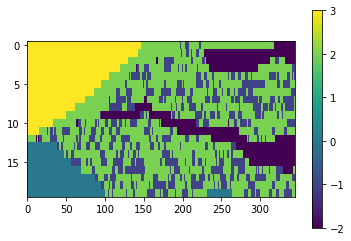

In [563]:
hk = np.ones((nlay,nrow,ncol),dtype=np.float64)
ibound = np.ones((nlay,nrow,ncol),dtype=np.int)

mps180 = np.load(MPSdir.joinpath('reals','mps180_16node.npy')).astype(np.float)
mps180[mps180==1]=hkSand
mps180[mps180==0]=hkClay
hk[np.where(layer_mapping_ind==0)] = 10000
hk[np.where(layer_mapping_ind==1)] = 100
hk[np.where(layer_mapping_ind==2)] = hkClay*.01
hk[np.where(layer_mapping_ind==3)] = mps180[np.where(layer_mapping_ind==3)]
hk[np.where(layer_mapping_ind==4)] = hkClay*.01
hk[np.where(layer_mapping_ind==5)] = mps180[np.where(layer_mapping_ind==5)]


plt.figure()
plt.imshow(np.log10(hk)[:,0,:],vmin=-2,vmax=3)
plt.gca().set_aspect(10)
plt.colorbar()

### BCs

In [564]:
def find_ocean(m,layer_mapping_ind):
    ocean_line = []

    for lay in range(m.dis.nlay):
        for row in range(m.dis.nrow):
            thislay = (lay,row,np.where(layer_mapping_ind[lay,row,:]!=0)[0][0])
            ocean_line.append(thislay)
            if lay==m.dis.nlay-1:
                pass
            else:
                nextlay = (lay+1,row,np.where(layer_mapping_ind[lay+1,row,:]!=0)[0][0])
                for col in np.arange(thislay[2],nextlay[2],-1):
                    ocean_line.append((lay,row,col))
    ocean_line = np.array(ocean_line).T


    ocean_grid = np.zeros((nlay,nrow,ncol),dtype=np.bool)
    ocean_grid[tuple(ocean_line)]=True
    ocean_grid[m.modelgrid.zvertices[1:,:,:]>ocean_elev]=False
    return ocean_line,ocean_grid

ocean_line,ocean_grid = find_ocean(m,layer_mapping_ind)

In [565]:
itype = flopy.mt3d.Mt3dSsm.itype_dict()
cond = 1000.

ghb_data_ocean = {}
ssm_data_ocean = {}
for kper in range(nper):
    if kper%50==0:
        print('kper',kper)
    ghb_per = []
    ssm_per = []
    #Ocean boundary
    for v in np.argwhere(ocean_grid):
        ghb_per.append([v[0],
                       v[1],
                       v[2],
                       #ocean_hf[3][j],
                        ocean_elev,
                       cond])
        #SSM: {stress_period: [lay,row,col,concentration,itype]}
        ssm_per.append([v[0],
                       v[1],
                       v[2],
                       Csalt,
                       itype['GHB']])
    ghb_data_ocean[kper]=ghb_per
    ssm_data_ocean[kper]=ssm_per
    
# print(np.where(ibound[tuple(np.array(ghb_data_ocean[0])[:,:3].astype(int).T)]==0))

inds = []
nix_ghb = []
for v in ocean_line.T:
# v = ocean_line.T[-1]
    if 6 in layer_mapping_ind[v[0],v[1],v[2]:v[2]+10]:
        inds.append((v[0],v[1],int(np.argwhere(layer_mapping_ind[v[0],v[1],v[2]:v[2]+10]==6)[0]) + v[2]))
        nix_ghb.append(v)

        
for kper in range(nper):
    for v in nix_ghb:
        try:
            ghb_data_ocean[kper].remove([v[0],v[1],v[2],0,cond])
            ssm_data_ocean[kper].remove([v[0],v[1],v[2],Csalt,itype['GHB']])
        except:
            continue


kper 0
kper 50


### Extend inland ghb time

In [566]:
bhead_mean_180=  []
bhead_mean_400 = []
bhead_180400 = []

for per in range(m_nm.nper):
    msk = np.logical_and(m_nm.ghb.stress_period_data[per]['j']==344,
                     m_nm.ghb.stress_period_data[per]['k']==3)
    bhead_mean_180.append(m_nm.ghb.stress_period_data[per][msk]['bhead'].mean())
    
    msk = np.logical_and(m_nm.ghb.stress_period_data[per]['j']==344,
                     m_nm.ghb.stress_period_data[per]['k']==5)
    bhead_mean_400.append(m_nm.ghb.stress_period_data[per][msk]['bhead'].mean())
    
    msk = np.logical_and(m_nm.ghb.stress_period_data[per]['j']==344,
                     m_nm.ghb.stress_period_data[per]['k']==4)
    bhead_180400.append(m_nm.ghb.stress_period_data[per][msk]['bhead'].mean())
    
    
    
    
yr = np.arange(2012,2019)
dlvl_180 = np.array([-2,-1,-8,-7,0,11,.5,2])*.3048
dlvl_400 = np.array([-1,-1,-7,-4,1,8,-.5,2])*.3048

bhead_future_180 = [np.array(bhead_mean_180)[-12:]+dlvl for dlvl in dlvl_180]
bhead_future_180 = np.array(bhead_future_180).flatten()
bhead_future_180 = np.r_[bhead_future_180,np.tile(bhead_future_180[-12:],20)]
bhead_future_180 = bhead_future_180[5::6]

bhead_future_400 = [np.array(bhead_mean_400)[-12:]+dlvl for dlvl in dlvl_400]
bhead_future_400 = np.array(bhead_future_400).flatten()
bhead_future_400 = np.r_[bhead_future_400,np.tile(bhead_future_400[-12:],20)]
bhead_future_400 = bhead_future_400[5::6]


inland_inds_180 = np.argwhere(layer_mapping_ind==3)
inland_inds_180 = inland_inds_180[inland_inds_180[:,2]==344,:]

inland_inds_180400 = np.argwhere(layer_mapping_ind==4)
inland_inds_180400 = inland_inds_180400[inland_inds_180400[:,2]==344,:]

inland_inds_400 = np.argwhere(layer_mapping_ind==5)
inland_inds_400 = inland_inds_400[inland_inds_400[:,2]==344,:]



### TESTING BLOCK

### Better way to do it:

##### Get m_nm ghb and dates

kper_m 0, date 1990.25
3 0 344 -2.711973508199055
3 1 344 -2.711973508199055
3 2 344 -2.711973508199055
3 3 344 -2.711973508199055
3 4 344 -2.711973508199055
3 5 344 -2.711973508199055
3 6 344 -2.711973508199055
3 7 344 -2.711973508199055
3 8 344 -2.711973508199055
3 9 344 -2.711973508199055
3 10 344 -2.711973508199055
3 11 344 -2.711973508199055
3 12 344 -2.711973508199055
3 13 344 -2.711973508199055
3 14 344 -2.711973508199055
3 15 344 -2.711973508199055
3 16 344 -2.711973508199055
3 17 344 -2.711973508199055
3 18 344 -2.711973508199055
3 0 344 -5.128991285959884
3 1 344 -5.128991285959884
3 2 344 -5.128991285959884
3 3 344 -5.128991285959884
3 4 344 -5.128991285959884
3 5 344 -5.128991285959884
3 6 344 -5.128991285959884
3 7 344 -5.128991285959884
3 8 344 -5.128991285959884
3 9 344 -5.128991285959884
3 10 344 -5.128991285959884
3 11 344 -5.128991285959884
3 12 344 -5.128991285959884
3 13 344 -5.128991285959884
3 14 344 -5.128991285959884
3 15 344 -5.128991285959884
3 16 344 -5.12899

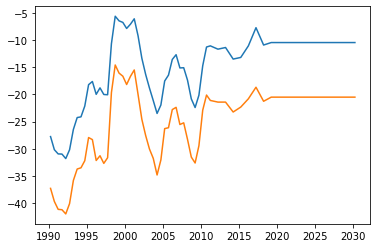

In [568]:
z_m_vert = m_empty.modelgrid.zvertices
def date_from_per(kper_m):
    return  (start_m_yr + start_m_mo/12) + np.sum(perlen[:kper_m])/365


bheads180 = []
bheads400 = []
dates = []
for kper_nm in range(m_nm.nper):
    ghb_per=[]
    ssm_per = []


    lay=3
    msk = np.logical_and(np.logical_and(np.isin(ghb_data_nm[kper_nm]['i'],rows),
                                                    ghb_data_nm[kper_nm]['j']==344)
                                     ,ghb_data_nm[kper_nm]['k']==lay)
    bheads180.append(ghb_data_nm[kper_nm][msk]['bhead'].mean())

    lay=5
    msk = np.logical_and(np.logical_and(np.isin(ghb_data_nm[kper_nm]['i'],rows),
                                                    ghb_data_nm[kper_nm]['j']==344)
                                     ,ghb_data_nm[kper_nm]['k']==lay)
    bheads400.append(ghb_data_nm[kper_nm][msk]['bhead'].mean())
    dates.append((start_nm_yr + start_nm_mo/12) + kper_nm/12)
    
    
bhead_future_180 = np.array([np.array(bheads180)[-12:]+dlvl for dlvl in dlvl_180]).flatten()
bhead_future_180 = np.r_[bhead_future_180,np.tile(bhead_future_180[-12:],20)]

bhead_future_400 = np.array([np.array(bheads400)[-12:]+dlvl for dlvl in dlvl_400]).flatten()
bhead_future_400 = np.r_[bhead_future_400,np.tile(bhead_future_400[-12:],20)]

dates_future = dates[-1] + np.linspace(1/12,1/12*len(bhead_future_180),len(bhead_future_180))


bheads180 = np.r_[bheads180,bhead_future_180]
bheads400 = np.r_[bheads400,bhead_future_400]
dates  = np.r_[dates,dates_future]


    
    
###Smooth and sample
    
from scipy.interpolate import interp1d

def conv_signal(x,N=2):
    bheads_conv = np.convolve(x, np.ones((N,))/N, mode='valid')
    if N%2==0:
        return np.r_[np.ones(int(np.floor((N-1)/2)))*bheads_conv[0],
                            bheads_conv,
                            np.ones(int(np.ceil((N-1)/2)))*bheads_conv[-1] ]
    else:
        return np.r_[np.ones(int((N-1)/2))*bheads_conv[0],
                     bheads_conv,
                     np.ones(int((N-1)/2))*bheads_conv[-1]]
    
    
dates_m = np.array([date_from_per(kper) for kper in range(m.nper)])
interpolator = interp1d(dates,conv_signal(bheads400,12),kind='cubic')

bheads180_interp = interp1d(dates,conv_signal(bheads180,12),kind='cubic')(dates_m)
bheads400_interp = interp1d(dates,conv_signal(bheads400,12),kind='cubic')(dates_m)


plt.plot(dates_m,bheads180_interp)
plt.plot(dates_m,bheads400_interp)
    
    
ghb_data_inland = {}
ssm_data_inland = {}
#Assign
for per in range(m.nper):
    ghb_per=[]
    ssm_per = []
    if per%10==0:
        print('kper_m {}, date {}'.format(per,dates_m[per]))
            
    for ind in inland_inds_180:
        k,i,j = ind
        bhead =bheads180_interp[per]
        if bhead < z_m_vert[k+1,i,j]:
            print(k,i,j,bhead - z_m_vert[k+1,i,j])
        else:
            ghb_per.append((k,i,j,bhead,cond))
            ssm_per.append([k,i,j,Cfresh,itype['GHB']])

    for ind in inland_inds_180400: #Same bhead as 180-FA
        k,i,j = ind
        bhead =bheads180_interp[per]
        if bhead < z_m_vert[k+1,i,j]:
            print(k,i,j,bhead - z_m_vert[k+1,i,j])
        else:
            ghb_per.append((k,i,j,bhead,cond))
            ssm_per.append([k,i,j,Cfresh,itype['GHB']])

    for ind in inland_inds_400:
        k,i,j = ind
        bhead =bheads400_interp[per]
        if bhead < z_m_vert[k+1,i,j]:
            print(k,i,j,bhead - z_m_vert[k+1,i,j])
        else:
            ghb_per.append((k,i,j,bhead,cond))
            ssm_per.append([k,i,j,Cfresh,itype['GHB']])
        
    ghb_data_inland[per]=ghb_per
    ssm_data_inland[per]=ssm_per  

##### Assign

### END TESTING BLOCK

### Adding the recharge

In [569]:
layer =1
f_exp = GISdir.joinpath("sva_edge_2","SVA_edge").as_posix()
int_sva = g.intersect(f_exp,'line',layer=layer)
g.nodes = g.get_nodes()
a = np.zeros((g.nodes), dtype=np.int)
a[int_sva.nodenumber] = 1
asva = a.reshape((nlay,nrow,ncol),order='C')

asva_inds = np.argwhere(asva)
# asva_inds_adj = asva_inds.copy()
# asva_inds_adj[:,2]=asva_inds_adj[:,2]-1
# asva_inds = np.r_[asva_inds,asva_inds_adj]
ibound[tuple(asva_inds.T)] = 1

rch_how = 'CHD'

### Add in the recharge as CHD

In [570]:
bhead  = .1
chd_data =  {}
ssm_rech = {}
for kper_m in range(nper):
    chd_per=[]
    ssm_per = []
    if kper_m%10==0:
        print('date: {}; kper_m {}'.format(
            date_from_per(kper_m),kper_m))
    
    for ind in asva_inds:
        k,i,j = ind
        chd_per.append([k,i,j-1,bhead,bhead]) #[lay, row, col, shead, ehead]
        ssm_per.append([k,i,j-1,Cfresh,itype['CHD']])
    
    chd_data[kper_m] = chd_per
    ssm_rech[kper_m] = ssm_per
#     ghb_data_inland[kper_m]=ghb_per
#     ssm_data_inland[kper_m]=ssm_per  

date: 1990.25; kper_m 0
date: 1995.25; kper_m 10
date: 2000.25; kper_m 20
date: 2005.25; kper_m 30
date: 2010.25; kper_m 40
date: 2015.25; kper_m 50
date: 2020.25; kper_m 60
date: 2025.25; kper_m 70
date: 2030.25; kper_m 80


### Add recharge as GHB

### Add recharge as RCH

### Merge GHB data, SSM data

In [571]:
ghb_data = {}
ssm_data = {}
for kper in range(nper):
    if kper%50==0:
        print('kper',kper)
    ghb_per = ghb_data_ocean[kper]
    ssm_per = ssm_data_ocean[kper]
    for vg,vs in zip(ghb_data_inland[kper],ssm_data_inland[kper]):
        ghb_per.append(vg)
        ssm_per.append(vs)
    
    #Add recharge data if coded as CHD/GHB/etc.. data
    for vc in ssm_rech[kper]:
        ssm_per.append(vc)
    
#     for vg in ghb_data_rech[kper]:
#         ghb_per.append(vg)
    
    ghb_data[kper] = ghb_per
    ssm_data[kper] = ssm_per

kper 0
kper 50


 ### STRT

In [572]:
yr_ind = np.argmin(np.abs([v - (start_m_yr + start_m_mo/12) for v in yrs_180]))
a_180 = intersect_swi_contour(aquifer=180,yr_ind=yr_ind)
nonzerolay = int(np.argwhere([v.any() for v in a_180]))
a_180 = np.tile(a_180[nonzerolay],(nlay,1,1))


yr_ind = np.argmin(np.abs([v - (start_m_yr + start_m_mo/12) for v in yrs_400]))
a_400 = intersect_swi_contour(aquifer=400,yr_ind=yr_ind)
nonzerolay = int(np.argwhere([v.any() for v in a_400]))
a_400 = np.tile(a_400[nonzerolay],(nlay,1,1))
salt_180 =np.logical_and(a_180==1,layer_mapping_ind==3)
salt_400 =np.logical_and(a_400==1,layer_mapping_ind==5)


salt_180 =np.logical_and(a_180==1,layer_mapping_ind==3)
for lay in range(nlay):
    for row in range(nrow):
        inds_nonzero = np.argwhere(salt_180[lay,row,:])
        if len(inds_nonzero)>0:
            salt_180[lay,row,:int(inds_nonzero[0])]=True
            
salt_400 =np.logical_and(a_400==1,layer_mapping_ind==5)
for lay in range(nlay):
    for row in range(nrow):
        inds_nonzero = np.argwhere(salt_400[lay,row,:])
        if len(inds_nonzero)>0:
            salt_400[lay,row,:int(inds_nonzero[0])]=True


In [573]:
ind_ocean = np.where(ocean_grid[0,0,:])[0].max()
# ocean_lay = np.where((layer_mapping_ind[:,row,:]==3).any(axis=1))[0].min() # highest layer within the 180-FA containing the ocean
# ind_ocean = np.where(ocean_grid[ocean_lay,0,:])[0].max() #farthest inland point for the given row corresponding to the ocean



saltgrad_180 = np.zeros_like(a_180)
for lay in range(nlay):
    for row in range(nrow):
        ind_max = np.argwhere(a_180[lay,row,:])
        if len(ind_max)>0:
#             ind_ocean = np.argwhere(ocean_grid[lay,row,:]).max()
            tds_vec = np.linspace(Csalt,250/1000, ind_max.max()-ind_ocean)
            saltgrad_180[lay,row,:ind_ocean]=Csalt
            saltgrad_180[lay,row,ind_ocean:ind_max.max()]=tds_vec
saltgrad_400 = np.zeros_like(a_400)
for lay in range(nlay):
    for row in range(nrow):
        ind_max = np.argwhere(a_400[lay,row,:])
        if len(ind_max)>0:
#             ind_ocean = np.argwhere(ocean_grid[lay,row,:]).max()
            tds_vec = np.linspace(Csalt,250/1000, ind_max.max()-ind_ocean)
            saltgrad_400[lay,row,:ind_ocean]=Csalt
            saltgrad_400[lay,row,ind_ocean:ind_max.max()]=tds_vec
 
            
            

In [574]:
# ibound = np.ones((nlay,nrow,ncol),dtype=np.int)
# for v in np.argwhere(ocean_grid):
#     ibound[v[0],v[1],:v[2]]=0
# head_inland =-10.
head_inland = min([np.min(np.array(v)[:,3]) for k,v in ghb_data_inland.items()])
# ibound = np.ones((nlay,nrow,ncol),dtype=np.int)
for lay in range(nlay):
    for row in range(nrow):
        col = int(np.argwhere(ocean_grid[lay,row,:])[0])
        ibound[lay,row,:col]=0
for v in inds:
    ibound[v[0],v[1],:v[2]]=0
# ibound[z_m_vert[1:,:,:]>0]=0
ibound[m_empty.modelgrid.zcellcenters > -1] = 0 
ibound[layer_mapping_ind==6]=0


strt = np.ones_like(ibound)*head_inland

# sconc=np.ones((nlay,nrow,ncol),dtype=np.float)*Cfresh
# sconc[ocean_grid] = Csalt
# # interface_start = np.array(get_line(ocean_line.T[0,1:],[nlay-1,int(ncol/2)],allrows=1))
# for v in ocean_line.T:
#     sconc[v[0],v[1],:v[2]]=Csalt
# sconc[np.logical_or(salt_180,salt_400)] = Csalt
    
sconc=np.ones((nlay,nrow,ncol),dtype=np.float)*Cfresh
sconc[np.isin(layer_mapping_ind,(3,1))] = saltgrad_180[np.isin(layer_mapping_ind,(3,1))]
sconc[np.isin(layer_mapping_ind,(5,1))] = saltgrad_400[np.isin(layer_mapping_ind,(5,1))]
# sconc[layer_mapping_ind==1] =Csalt
sconc[ocean_grid] = Csalt
# interface_start = np.array(get_line(ocean_line.T[0,1:],[nlay-1,int(ncol/2)],allrows=1))
for v in ocean_line.T:
    sconc[v[0],v[1],:v[2]]=Csalt
    
    
    

icbund = np.ones((nlay, nrow, ncol), dtype=np.int)
icbund[np.where(ibound==-1)] = -1

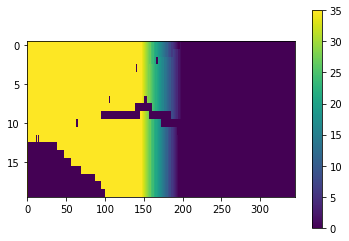

In [575]:
plt.imshow(sconc[:,0,:])
plt.gca().set_aspect(10)
plt.colorbar()

In [576]:
# In[9]:

#Output control
oc_data = {}
for kper in range(nper):
    oc_data[(kper,0)] = ['save head','save budget']


# In[10]:

#Create instances in flopy
bas = flopy.modflow.ModflowBas(m, ibound=ibound, strt=strt)
ghb = flopy.modflow.ModflowGhb(m, stress_period_data=ghb_data)

if rch_how is 'CHD':
    chd = flopy.modflow.ModflowChd(m, stress_period_data=chd_data)
elif rch_how is 'RCH':
    rch = flopy.modflow.ModflowRch(m,rech=rech_data)

# rch = flopy.modflow.ModflowRch(m, rech=rech_data)
# wel = flopy.modflow.ModflowWel(m, stress_period_data=wel_data, ipakcb=ipakcb)
# riv = flopy.modflow.ModflowRiv(m, stress_period_data=riv_data)
# Add LPF package to the MODFLOW model
ipakcb = 53
lpf = flopy.modflow.ModflowLpf(m, hk=hk, vka=vka, ipakcb=ipakcb,laytyp=0,laywet=0,
                              ss=ss,sy=sy)

# Add PCG Package to the MODFLOW model
pcg = flopy.modflow.ModflowPcg(m, hclose=1.e-8)

# Add OC package to the MODFLOW model
oc = flopy.modflow.ModflowOc(m,
                             stress_period_data=oc_data,
                             compact=True)

#Create the basic MT3DMS model structure
timprs = np.cumsum(m.DIS.perlen.array)
btn = flopy.mt3d.Mt3dBtn(m,
                         laycon=lpf.laytyp, htop=henry_top,
                         dz=dis.thickness.get_value(), prsity=por, icbund=icbund,
                         sconc=sconc, nprs=1,timprs=timprs)
# adv = flopy.mt3d.Mt3dAdv(m, mixelm=-1 )
adv = flopy.mt3d.Mt3dAdv(m, mixelm=0,nadvfd=0 )

dsp = flopy.mt3d.Mt3dDsp(m, al=al, dmcoef=dmcoef)
gcg = flopy.mt3d.Mt3dGcg(m, iter1=50, mxiter=1, isolve=3, cclose=1e-4)
ssm = flopy.mt3d.Mt3dSsm(m, stress_period_data=ssm_data,mxss=len(ssm_data[0])*nper)

#vdf = flopy.seawat.SeawatVdf(m, iwtable=0, densemin=0, densemax=0,denseref=1000., denseslp=0.7143, firstdt=1e-3)
vdf = flopy.seawat.SeawatVdf(m, mtdnconc=1, mfnadvfd=1, nswtcpl=0, iwtable=0,
                             densemin=0., densemax=0., denseslp=denseslp, denseref=densefresh)


for pak in ['RCH','CHD',]:
    if pak is not rch_how:
        try:
            m.remove_package(pak)
        except:
            pass

adding Package:  BAS6
adding Package:  GHB
adding Package:  CHD
Adding NM.cbc (unit=53) to the output list.
adding Package:  LPF
adding Package:  PCG
Adding NM.hds (unit=51) to the output list.
adding Package:  OC
adding Package:  BTN
adding Package:  ADV
adding Package:  DSP
adding Package:  GCG
   explicit cevt in file
adding Package:  SSM
adding Package:  VDF


Text(0.5, 0, 'X UTM (m)')

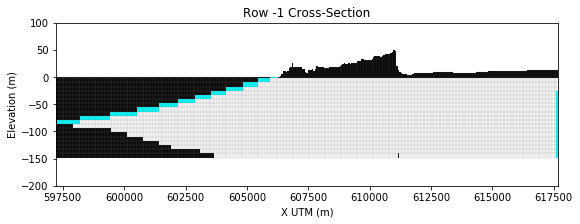

In [577]:
from matplotlib import cm

slicetype='Row'
slicenum= -1

# First step is to set up the plot
fig = plt.figure(figsize=(9, 3))
ax = fig.add_subplot(1, 1, 1)

# Next we create an instance of the PlotCrossSection class
xsect = flopy.plot.PlotCrossSection(model=m, line={slicetype: slicenum},geographic_coords=True)
# xsect.plot_ibound()
xsect.plot_grid(linewidth=.1)
# Then we can use the plot_grid() method to draw the grid
# The return value for this function is a matplotlib LineCollection object,
# which could be manipulated (or used) later if necessary.
# linecollection = xsect.plot_grid()
# patches = xsect.plot_ibound()
# csa = xsect.plot_array(layer_mapping_ind)
# cmap = cm.get_cmap('tab10', lay_m.shape[0])
# csa = xsect.plot_array(conc,cmap='jet')
# c = plt.colorbar(csa)
# wel = xsect.plot_bc("CHD")
wel = xsect.plot_ibound()
wel = xsect.plot_bc("GHB")
# wel = xsect.plot_bc("RCH")

# wel = xsect.plot_bc("CHD")

# csa = xsect.plot_array(m.bas6.ibound,cmap='jet')




t = ax.set_title('{slicetype} {slicenum} Cross-Section'.format(slicetype=slicetype,slicenum=slicenum))
plt.ylabel('Elevation (m)')
plt.ylim((-200,100))
plt.xlabel('X UTM (m)')
# c.set_label('log10(hk)')
# plt.savefig(figdir.joinpath('seawat_fine_xsection_layers_{slicetype}{slicenum}.png'.format(slicetype=slicetype,slicenum=slicenum)),dpi=300,bbox_inches='tight')

In [578]:
ghb.check()
ssm.check()


GHB PACKAGE DATA VALIDATION:
  No errors or warnings encountered.

  Checks that passed:
    BC indices valid
    not a number (Nan) entries
    BC in inactive cells
    BC elevation below cell bottom


SSM PACKAGE DATA VALIDATION:
  No errors or warnings encountered.

  Checks that passed:
    BC indices valid
    not a number (Nan) entries
    BC in inactive cells



In [579]:
%%time
writeyn= True
runyn = False
#Write input
if writeyn:
    m.write_input()

# Try to delete the output files, to prevent accidental use of older files

f_delete = [os.path.join(model_ws,'MT3D.CNF'),
            os.path.join(model_ws,'MT3D001.MAS'),
            os.path.join(model_ws, 'MT3D001.UCN'),
            os.path.join(model_ws, modelname + '.hds'),
            os.path.join(model_ws, modelname + '.cbc')]

for f in f_delete:
    try:
        os.remove(f)
    except:
        pass

#%%
import datetime

if runyn:
    #Run model
    ts = make_timestamp()
    v = m.run_model(silent=False, report=True)
    for idx in range(-3, 0):
        print(v[1][idx])
else:
    print('Not running model!')
# In[14]:


Writing packages:
   Package:  DIS
   Package:  BAS6
   Package:  GHB
   Package:  CHD
   Package:  LPF
   Package:  PCG
   Package:  OC
   Package:  BTN
   Package:  ADV
   Package:  DSP
   Package:  GCG
   Package:  SSM
   Package:  VDF
 
Not running model!
CPU times: user 9.28 s, sys: 163 ms, total: 9.44 s
Wall time: 10.7 s


In [580]:
m.model_ws

'../work/NM'

### Post processing

In [548]:
fname = model_ws.joinpath('MT3D001.UCN').as_posix()
anyvals= []
ucnobj = flopy.utils.binaryfile.UcnFile(fname,verbose=False)
# if kstpkper==None:
kstpkpers = ucnobj.get_kstpkper()
for kstpkper in kstpkpers:
    conc = ucnobj.get_data(kstpkper=kstpkper)
    anyvals.append(np.logical_and(conc < 100., conc>0.).any())
print(anyvals)


conc = ucnobj.get_data(kstpkper=kstpkpers[-1])
conc[conc > 100]=np.nan


fname = model_ws.joinpath(m.name +'.hds').as_posix()
hdobj = flopy.utils.binaryfile.HeadFile(fname,verbose=False)
kstpkpers = hdobj.get_kstpkper()
hd = hdobj.get_data(kstpkper=kstpkpers[-1])
hd[hd<-100]=np.nan

[True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True]


Text(0.5, 0, 'X UTM (m)')

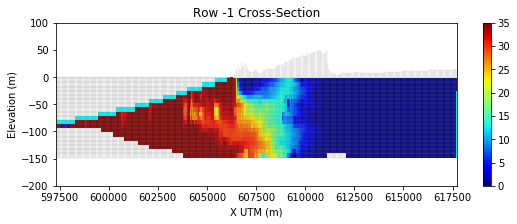

In [553]:
from matplotlib import cm

conc = ucnobj.get_data(kstpkper=kstpkpers[30])
conc[conc > 100]=np.nan



slicetype='Row'
slicenum= -1

# First step is to set up the plot
fig = plt.figure(figsize=(9, 3))
ax = fig.add_subplot(1, 1, 1)

# Next we create an instance of the PlotCrossSection class
xsect = flopy.plot.PlotCrossSection(model=m, line={slicetype: slicenum},geographic_coords=True)
# xsect.plot_ibound()
xsect.plot_grid(linewidth=.1)
# Then we can use the plot_grid() method to draw the grid
# The return value for this function is a matplotlib LineCollection object,
# which could be manipulated (or used) later if necessary.
# linecollection = xsect.plot_grid()
# patches = xsect.plot_ibound()
# csa = xsect.plot_array(layer_mapping_ind)
# cmap = cm.get_cmap('tab10', lay_m.shape[0])
# xsect.contour_array(conc,cmap='jet',levels=np.array([.05,.5,.95])*Csalt)
csa = xsect.plot_array(conc,cmap='jet',vmin=Cfresh,vmax=Csalt)
# csa = xsect.plot_array(hd)

c = plt.colorbar(csa)
# wel = xsect.plot_bc("CHD")
wel = xsect.plot_bc("GHB")



t = ax.set_title('{slicetype} {slicenum} Cross-Section'.format(slicetype=slicetype,slicenum=slicenum))
plt.ylabel('Elevation (m)')
plt.ylim((-200,100))
plt.xlabel('X UTM (m)')
# c.set_label('log10(hk)')
# plt.savefig(figdir.joinpath('seawat_fine_xsection_layers_{slicetype}{slicenum}.png'.format(slicetype=slicetype,slicenum=slicenum)),dpi=300,bbox_inches='tight')

In [ ]:
flopy.utils.binaryfile.

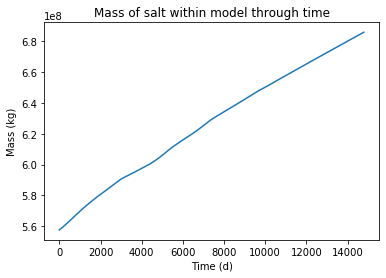

In [550]:
fname = os.path.join(m.model_ws, 'MT3D001.MAS')
mas = flopy.mt3d.Mt3dms.load_mas(fname)
f = plt.figure()
ax = f.add_subplot(1, 1, 1)
plt.xlabel('Time (d)')
plt.ylabel('Mass (kg)')
plt.title('Mass of salt within model through time')
lines = ax.plot(mas.time, mas.total_mass)
plt.show()
